# Vehicle Detection

### Project Dependencies

In [333]:
import os
import glob
import time
import random

from collections import deque

import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from pandas import DataFrame

from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Constants

In [2]:
TEST_IMAGES_DIR = "test_images"
INPUT_VIDEOS_DIR = "input_videos"
OUTPUT_VIDEOS_DIR = "output_videos"
VEHICLES_DIR = "vehicles"
NON_VEHICLES_DIR = "non_vehicles"

### Labeled Training Data

In [3]:
car_images = glob.glob(os.path.join(VEHICLES_DIR, "*", "*.png"))
notcar_images = glob.glob(os.path.join(NON_VEHICLES_DIR, "*", "*.png"))
print("Car Images: {}".format(len(car_images)))
print("Non-car Images: {}".format(len(notcar_images)))

Car Images: 8792
Non-car Images: 8968


## Histograms of Color

In [4]:
image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, 'cutout1.jpg'))

def color_hist(img, nbins=32, vis=False, bins_range=(0, 256)):
    """
    Compute the histogram of each color channel separately.
    PNGs read with mpimg will have values between 0.0 and 1.0, so `bins_range`
    should be changed accordingly
    """
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    bin_edges = ch1[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1]) / 2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1[0], ch2[0], ch3[0]))

    # Return the individual histograms, bin_centers and feature vector
    if vis:
        return ch1, ch2, ch3, bin_centers, hist_features
    return hist_features

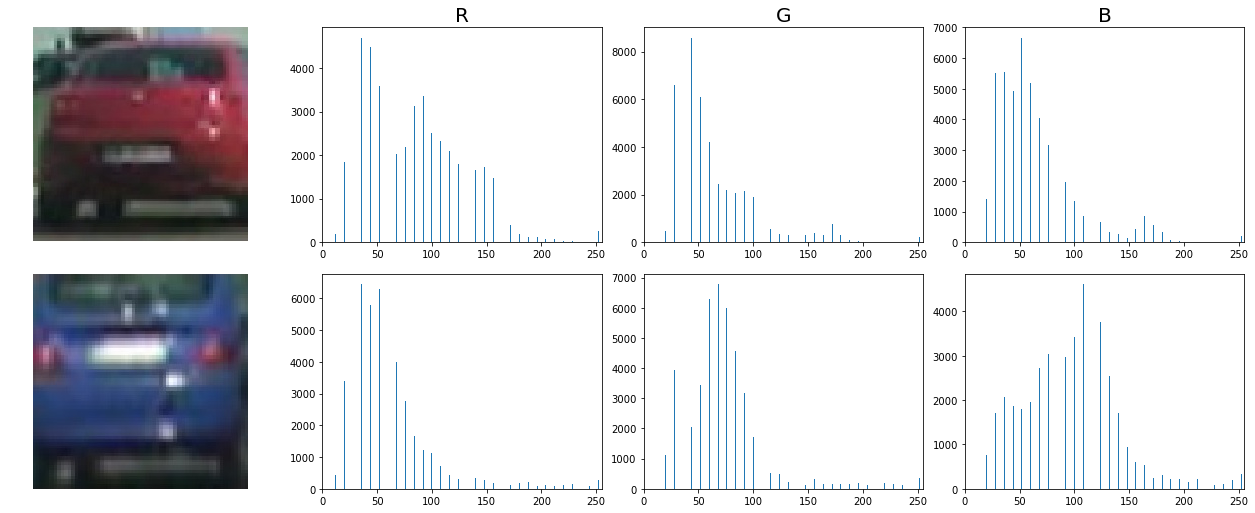

In [5]:
templist = ["cutout7.jpg", "cutout8.jpg"]

fig, axs = plt.subplots(2, 4, figsize=(18, 7))
fig.tight_layout()
for i, row in enumerate(axs):
    car_img = mpimg.imread(os.path.join(TEST_IMAGES_DIR, templist[i]))
    rh, gh, bh, bincen, feature_vec = color_hist(car_img, nbins=32, vis=True, bins_range=(0, 256))
    ax1, ax2, ax3, ax4 = row
    ax1.axis("off")
    ax1.imshow(car_img)
    ax2.bar(bincen, rh[0])
    ax2.set_xlim([0, 255])
    ax3.bar(bincen, gh[0])
    ax3.set_xlim([0, 255])
    ax4.bar(bincen, bh[0])
    ax4.set_xlim([0, 255])
    if i == 0:
        ax2.set_title("R", fontsize=20)
        ax3.set_title("G", fontsize=20)
        ax4.set_title("B", fontsize=20)

## Spatial Binning

In [6]:
def bin_spatial(img, size=(32, 32)):
    """
    Compute binned color features for each color channel
    """
    ch1 = cv2.resize(img[:,:,0], size).ravel()
    ch2 = cv2.resize(img[:,:,1], size).ravel()
    ch3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((ch1, ch2, ch3))

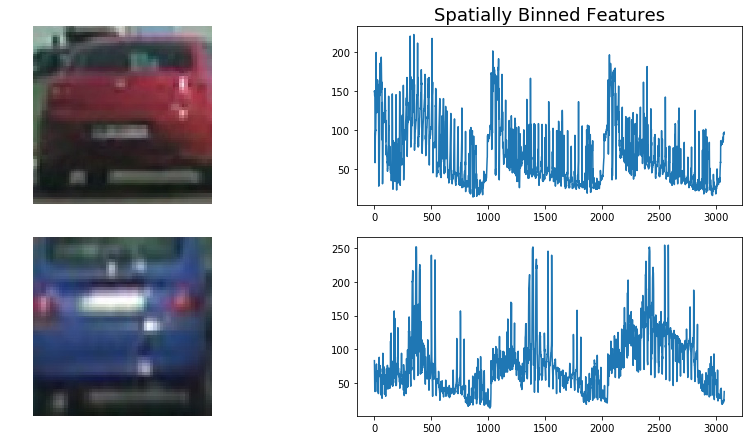

In [7]:
templist = ["cutout7.jpg", "cutout8.jpg"]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
fig.tight_layout()
for i, row in enumerate(axs):
    car_img = mpimg.imread(os.path.join(TEST_IMAGES_DIR, templist[i]))
    feature_vec = bin_spatial(car_img, size=(32, 32))
    ax1, ax2 = row
    ax1.axis("off")
    ax1.imshow(car_img)
    ax2.plot(feature_vec)
    if i == 0:
        ax2.set_title("Spatially Binned Features", fontsize=18)

## Histogram of Oriented Gradients (HOG)

In [8]:
def get_hog_features(img, orientations=9, px_per_cell=8, cells_per_block=2, vis=False, feature_vec=True):
    """
    Compute the Histogram of Oriented Gradients feature descriptor
    If `vis=True`, return a visualization image
    """
    return hog(img,
               orientations=orientations,
               pixels_per_cell=(px_per_cell, px_per_cell),
               cells_per_block=(cells_per_block, cells_per_block),
               transform_sqrt=False,
               visualise=vis,
               feature_vector=feature_vec)

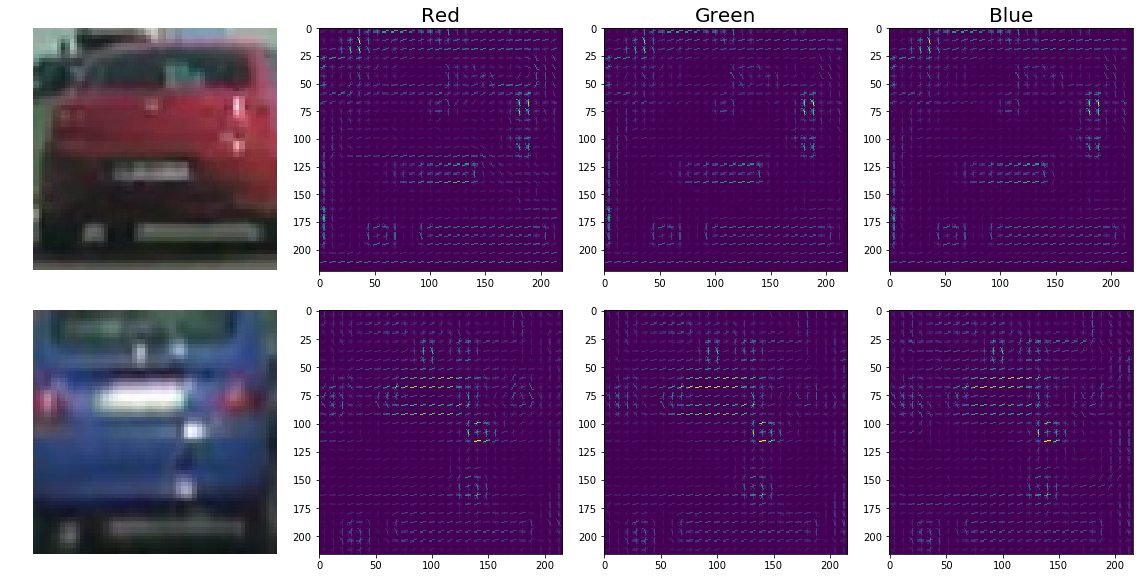

In [9]:
templist = ["cutout7.jpg", "cutout8.jpg"]

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.tight_layout()
for i, row in enumerate(axs):
    car_img = mpimg.imread(os.path.join(TEST_IMAGES_DIR, templist[i]))
    _,hog1 = get_hog_features(car_img[:,:,0], vis=True)
    _,hog2 = get_hog_features(car_img[:,:,1], vis=True)
    _,hog3 = get_hog_features(car_img[:,:,2], vis=True)
    ax1, ax2, ax3, ax4 = row
    ax1.axis("off")
    ax1.imshow(car_img)
    ax2.imshow(hog1)
    ax3.imshow(hog2)
    ax4.imshow(hog3)
    if i == 0:
        ax2.set_title("Red", fontsize=20)
        ax3.set_title("Green", fontsize=20)
        ax4.set_title("Blue", fontsize=20)

### Exploring Alternative Color Spaces

In [10]:
def convert_color(img, conv="RGB"):
    if conv == "YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == "HSV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == "YUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == "LUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == "GRAY":
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

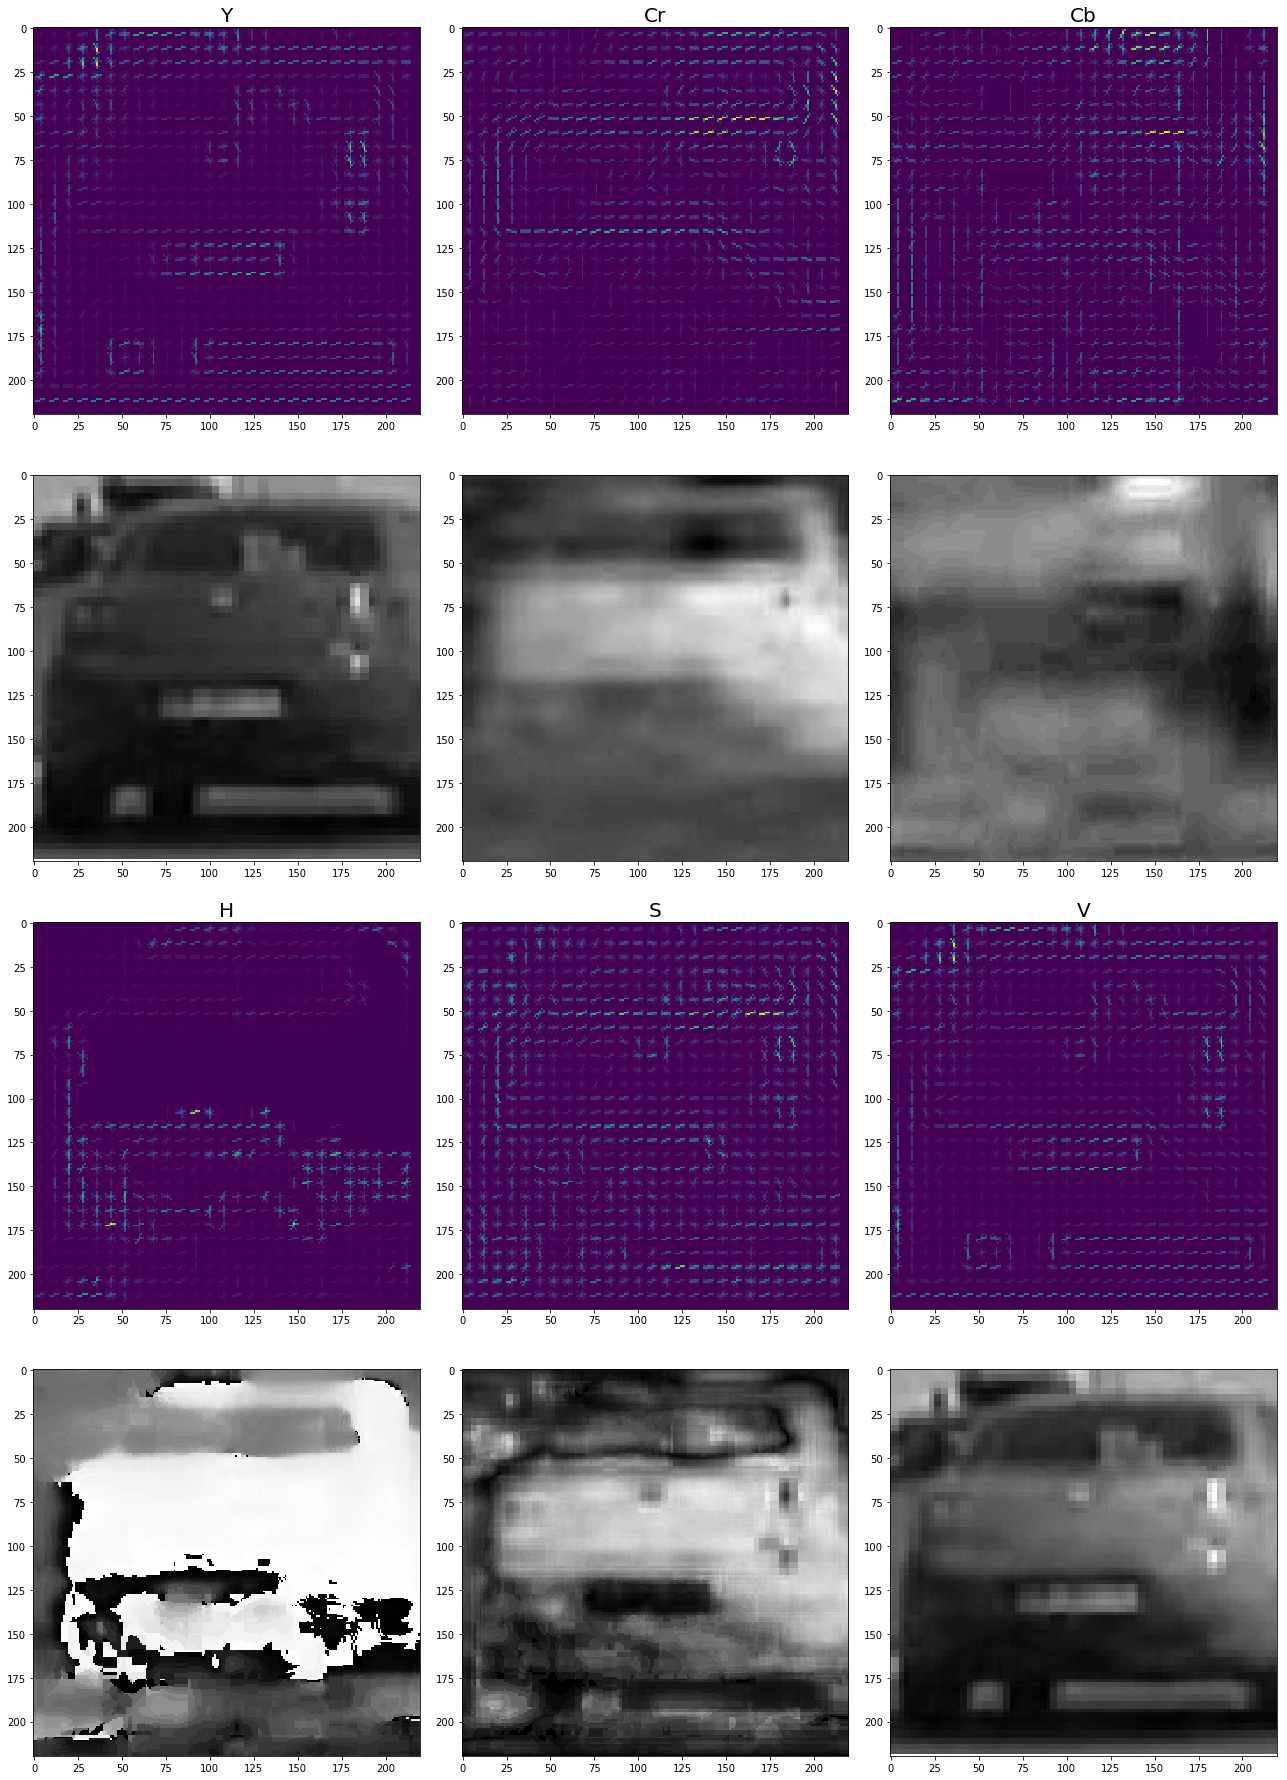

In [11]:
templist = ["cutout7.jpg"]
color_spaces = [('Y','Cr','Cb'), ('H','S','V')]

fig, axs = plt.subplots(4, 3, figsize=(18, 25))
fig.tight_layout()
for i, row in enumerate(axs):
    car_img = mpimg.imread(os.path.join(TEST_IMAGES_DIR, templist[0]))
    color_space = color_spaces[i // 2]
    conv = convert_color(car_img, conv="".join(color_space))
    ax1, ax2, ax3 = row
    if i % 2 == 0:
        _,hog1 = get_hog_features(conv[:,:,0], vis=True)
        _,hog2 = get_hog_features(conv[:,:,1], vis=True)
        _,hog3 = get_hog_features(conv[:,:,2], vis=True)
        ax1.imshow(hog1)
        ax2.imshow(hog2)
        ax3.imshow(hog3)
        ax1.set_title(color_space[0], fontsize=20)
        ax2.set_title(color_space[1], fontsize=20)
        ax3.set_title(color_space[2], fontsize=20)
    else:
        ax1.imshow(conv[:,:,0], cmap="gray")
        ax2.imshow(conv[:,:,1], cmap="gray")
        ax3.imshow(conv[:,:,2], cmap="gray")

### Combining Features

In [12]:
def extract_features(img_files,
                     color_space="YCrCb",
                     spatial_size=(32, 32),
                     hist_bins=32,
                     orientations=9,
                     px_per_cell=8,
                     cells_per_block=2,
                     hist_feat=True,
                     spatial_feat=True,
                     hog_feat=True):
    features_list = []
    for file_name in img_files:
        features = []
        img = mpimg.imread(file_name)
        feature_img = convert_color(img, conv=color_space)
        
        if hist_feat:
            hist_features = color_hist(feature_img, nbins=hist_bins, bins_range=(0., 1.))
            features.append(hist_features)
        if spatial_feat:
            spatial_features = bin_spatial(feature_img, size=spatial_size)
            features.append(spatial_features)
        if hog_feat:
            hog1 = get_hog_features(feature_img[:,:,0], orientations, px_per_cell, cells_per_block)
            hog2 = get_hog_features(feature_img[:,:,1], orientations, px_per_cell, cells_per_block)
            hog3 = get_hog_features(feature_img[:,:,2], orientations, px_per_cell, cells_per_block)
            features.append(np.hstack((hog1, hog2, hog3)))
        features_list.append(np.concatenate(features))
    return features_list

In [13]:
sample_size = 100

car_features = extract_features(random.sample(car_images, sample_size))

notcar_features = extract_features(random.sample(notcar_images, sample_size))

### Feature Normalization

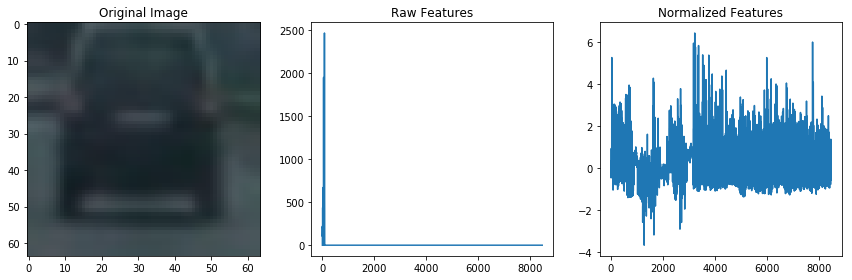

In [14]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

if len(car_features) > 0:
    car_ind = np.random.randint(0, sample_size)
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()

### Label the Data and Split into Training and Test Sets

In [15]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

## Evaluating Classifiers and Features

In [331]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

svc_linear = LinearSVC()
k_neighbors = KNeighborsClassifier(5)
ml_perceptron = MLPClassifier()

In [ ]:
def evaluate_classifier(clf, features, cname, X_data, y_labels, size=500, folds=5):
    scores = cross_val_score(clf, X_data[:size], y_labels[:size], cv=folds)
    accuracy = round(scores.mean(), 3)
    confidence = "+/- {:.3f}".format(scores.std() * 2)
    return features, cname, accuracy, confidence

def feature_permutator(spatial, color, hog, cars, notcars, dataframe, index, spatial_size=(32,32), hist_bins=32):
    car_features = extract_features(cars,
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins,
                                    spatial_feat=spatial,
                                    hist_feat=color,
                                    hog_feat=hog)

    notcar_features = extract_features(notcars,
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       spatial_feat=spatial,
                                       hist_feat=color,
                                       hog_feat=hog)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=np.random.randint(0, 100))
    n_features = len(X_train[0])

    feature_ids = np.array(["Spatial", "Hist", "HOG"])
    feat_names = '+'.join(feature_ids[[spatial, color, hog]])
    if not spatial:
        spatial_size = "NA"
    if not color:
        hist_bins = "NA"
    extra = (spatial_size, hist_bins, n_features)
    dataframe.loc[index] = evaluate_classifier(svc_linear, feat_names, "LinSVC", X_train, y_train) + extra
    dataframe.loc[index+1] = evaluate_classifier(k_neighbors, feat_names, "KNN", X_train, y_train) + extra
    dataframe.loc[index+2] = evaluate_classifier(ml_perceptron, feat_names, "MLP", X_train, y_train) + extra

### Various Feature/Classifier Combinations

In [ ]:
sample_size = 500
cars = random.sample(car_images, sample_size)
notcars = random.sample(notcar_images, sample_size)

df = DataFrame(columns=["descriptor", "clf", "accur", "conf", "spatial", "histbins","nfeat"])
feature_permutator(True, False, False, cars, notcars, df, 0)
feature_permutator(False, True, False, cars, notcars, df, 3)
feature_permutator(False, False, True, cars, notcars, df, 6)
feature_permutator(True, True, False, cars, notcars, df, 9)
feature_permutator(True, False, True, cars, notcars, df, 12)
feature_permutator(False, True, True, cars, notcars, df, 15)
feature_permutator(True, True, True, cars, notcars, df, 18)

### Varying Spatial Size and Color Histogram Bins

In [ ]:
feature_permutator(True, True, True, cars, notcars, df, 21, spatial_size=(32,32), hist_bins=8)
feature_permutator(True, True, True, cars, notcars, df, 24, spatial_size=(32,32), hist_bins=16)
feature_permutator(True, True, True, cars, notcars, df, 27, spatial_size=(32,32), hist_bins=32)
feature_permutator(True, True, True, cars, notcars, df, 30, spatial_size=(32,32), hist_bins=64)
feature_permutator(True, True, True, cars, notcars, df, 33, spatial_size=(32,32), hist_bins=128)
feature_permutator(True, True, True, cars, notcars, df, 36, spatial_size=(32,32), hist_bins=256)
feature_permutator(True, True, True, cars, notcars, df, 39, spatial_size=(16,16), hist_bins=8)
feature_permutator(True, True, True, cars, notcars, df, 42, spatial_size=(16,16), hist_bins=16)
feature_permutator(True, True, True, cars, notcars, df, 45, spatial_size=(16,16), hist_bins=32)
feature_permutator(True, True, True, cars, notcars, df, 48, spatial_size=(16,16), hist_bins=64)
feature_permutator(True, True, True, cars, notcars, df, 51, spatial_size=(16,16), hist_bins=128)
feature_permutator(True, True, True, cars, notcars, df, 54, spatial_size=(16,16), hist_bins=256)

### Removing Spatial Binned Features

In [ ]:
feature_permutator(False, True, True, cars, notcars, df, 57, hist_bins=8)
feature_permutator(False, True, True, cars, notcars, df, 60, hist_bins=16)
feature_permutator(False, True, True, cars, notcars, df, 63, hist_bins=32)
feature_permutator(False, True, True, cars, notcars, df, 66, hist_bins=64)
feature_permutator(False, True, True, cars, notcars, df, 69, hist_bins=128)
feature_permutator(False, True, True, cars, notcars, df, 72, hist_bins=256)

### Findings

In [ ]:
print(df.sort_values(["acc"], ascending=False))

### Training the Model

In [334]:
def fit_model(cars, notcars, classifier, spatial_size=(32, 32), hist_bins=128, spatial_feat=True, hist_feat=True, hog_feat=True):
    car_features = extract_features(cars,
                                    spatial_size=spatial_size,
                                    hist_bins=hist_bins,
                                    spatial_feat=spatial_feat,
                                    hist_feat=hist_feat,
                                    hog_feat=hog_feat)

    notcar_features = extract_features(notcars,
                                       spatial_size=spatial_size,
                                       hist_bins=hist_bins,
                                       spatial_feat=spatial_feat,
                                       hist_feat=hist_feat,
                                       hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=np.random.randint(0, 100))

    classifier.fit(X_train, y_train)
    return clf, X_scaler

model, scaler = fit_model(car_images, notcar_images, ml_perceptron, spatial_feat=False)

# Save trained model and scaler
joblib.dump(model, "model_mlp_o12_p8_c2_nospat_nohist.pkl")
joblib.dump(scaler, "scaler_mlp_nospat_hb128.pkl")

['scaler_mlp.pkl']

### Sliding Windows

In [392]:
def slide_windows(img,
                  ystart,
                  ystop,
                  scale,
                  x_offset=200,
                  cell_steps=2,
                  orientations=12,
                  px_per_cell=16,
                  cells_per_block=2,
                  block_color=(0,0,255)):
    draw_img = np.copy(img)

    img = img.astype(np.float32) / 255
    search_img = convert_color(img[ystart:ystop,:,:], conv='RGB2YCrCb')
    ctrans_tosearch = search_img
    if scale != 1:
        rows, cols = search_img.shape[:2]
        search_img = cv2.resize(search_img, (int(cols/scale), int(rows/scale)))

    nyblocks = (search_img.shape[0] // px_per_cell)
    nxblocks = (search_img.shape[1] // px_per_cell)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // px_per_cell) - cells_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cell_steps
    nysteps = (nyblocks - nblocks_per_window) // cell_steps

    for yb in range(nysteps):
        ypos = yb * cell_steps
        ypos_end = ypos + nblocks_per_window

        ytop = ypos * px_per_cell
        ybottom = ytop + window

        box_top = int(ytop * scale) + ystart
        box_bottom = int(ybottom * scale) + ystart
        for xb in range(nxsteps):
            xpos = xb * cell_steps
            xpos_end = xpos + nblocks_per_window

            xleft = xpos * px_per_cell
            xright = xleft + window

            box_left = int(xleft * scale)
            box_right = int(xright * scale)
            cv2.rectangle(draw_img, (box_left,box_top), (box_right,box_bottom), block_color, 2)
    return draw_img

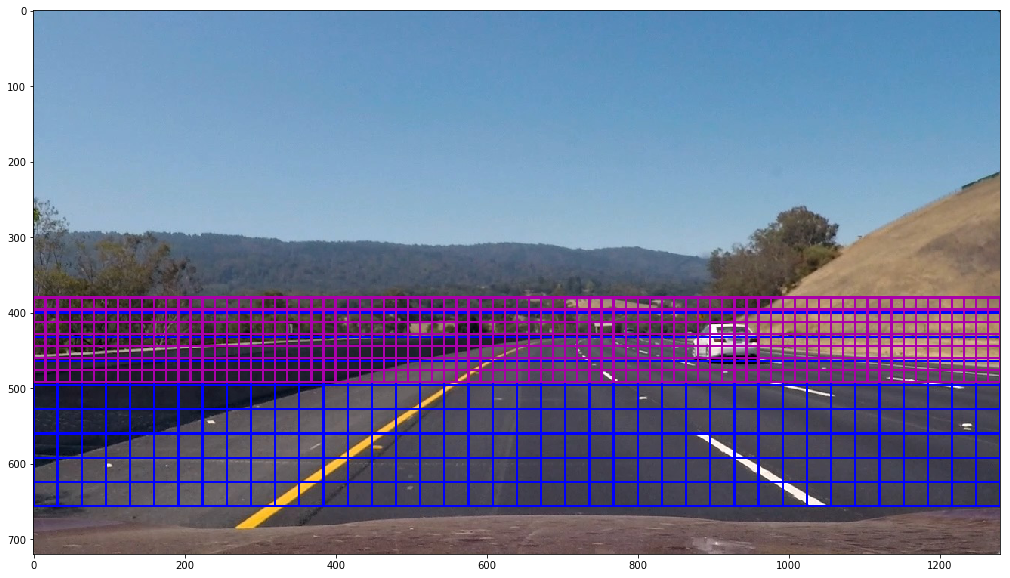

In [393]:
image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, 'test3.jpg'))

image = slide_windows(image, 400, 672, 2, cell_steps=1, block_color=(0,0,255))
image = slide_windows(image, 380, 500, 1, cell_steps=1, block_color=(170,0,170))

plt.figure(figsize=(20,10))
plt.imshow(image)

## Combining Classifiers and Window Search

In [385]:
def slide_window_search(img,
                        model,
                        scaler,
                        ystart,
                        ystop,
                        scale,
                        cell_steps=2,
                        orientations=9,
                        px_per_cell=8,
                        cells_per_block=2,
                        model_type="svc",
                        block_color=(0,0,255)):
    img = img.astype(np.float32) / 255
    search_img = convert_color(img[ystart:ystop,:,:], conv='RGB2YCrCb')
    if scale != 1:
        rows, cols = search_img.shape[:2]
        search_img = cv2.resize(search_img, (int(cols/scale), int(rows/scale)))

    nyblocks = (search_img.shape[0] // px_per_cell)
    nxblocks = (search_img.shape[1] // px_per_cell)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // px_per_cell) - cells_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cell_steps
    nysteps = (nyblocks - nblocks_per_window) // cell_steps
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(search_img[:,:,0], orientations, px_per_cell, cells_per_block, feature_vec=False)
    hog2 = get_hog_features(search_img[:,:,1], orientations, px_per_cell, cells_per_block, feature_vec=False)
    hog3 = get_hog_features(search_img[:,:,2], orientations, px_per_cell, cells_per_block, feature_vec=False)

    heatmap = np.zeros_like(image[:,:,0])
    for yb in range(nysteps):
        ypos = yb * cell_steps
        ypos_end = ypos + nblocks_per_window

        ytop = ypos * px_per_cell
        ybottom = ytop + window

        box_top = int(ytop * scale) + ystart
        box_bottom = int(ybottom * scale) + ystart
        for xb in range(nxsteps):
            # Extract HOG for this patch
            xpos = xb * cell_steps
            xpos_end = xpos + nblocks_per_window
            hog_feat1 = hog1[ypos:ypos_end, xpos:xpos_end].ravel() 
            hog_feat2 = hog2[ypos:ypos_end, xpos:xpos_end].ravel() 
            hog_feat3 = hog3[ypos:ypos_end, xpos:xpos_end].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            # Get color histogram features
            xleft = xpos*px_per_cell
            xright = xleft + window
            subimg = cv2.resize(search_img[ytop:ybottom, xleft:xright], (64,64))
            hist_features = color_hist(subimg, nbins=128)
            # spatial_features = bin_spatial(subimg, size=(32,32))

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((hist_features, hog_features)))

            if model_type == "svc":
                test_prediction = model.decision_function(test_features)[0]
                is_probably_car = test_prediction > 1.2
            elif model_type == "mlp":
                test_prediction = model.predict_proba(test_features)[0,1]
                is_probably_car = test_prediction > 0.999

            if is_probably_car:
                box_left = int(xleft * scale)
                box_right = int(xright * scale)
                heatmap[box_top:box_bottom, box_left:box_right] += 1
    return heatmap

### Heatmap

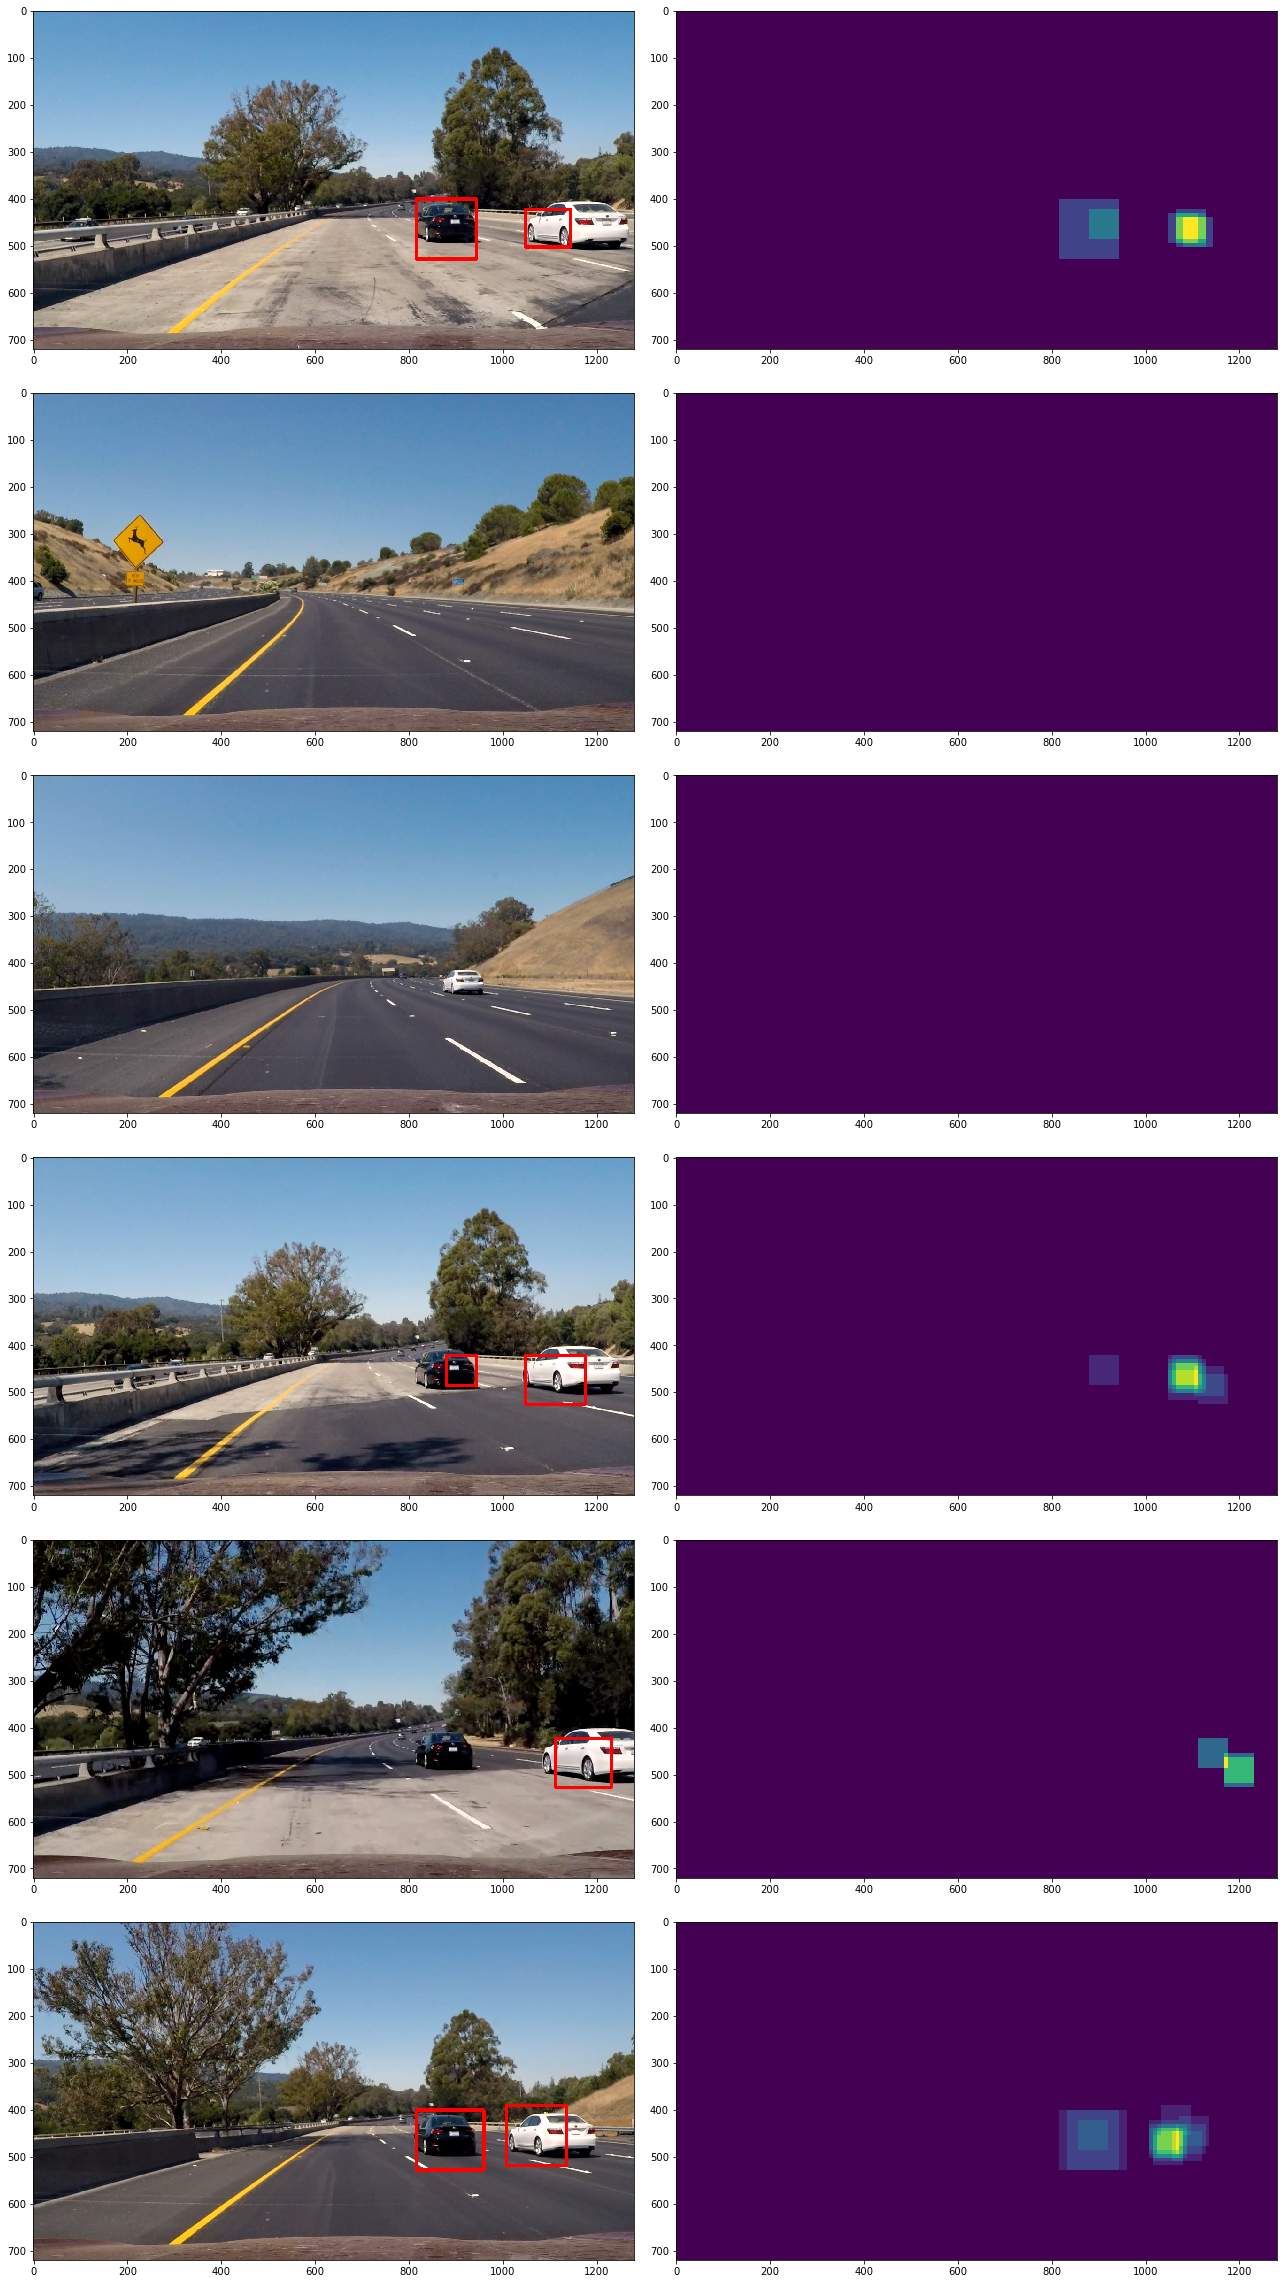

In [387]:
model = joblib.load("models/model_mlp_nospat_hb128.pkl")
scaler = joblib.load("models/scaler_mlp_nospat_hb128.pkl")

fig, axs = plt.subplots(6, 2, figsize=(18, 32))
fig.tight_layout()
for i, row in enumerate(axs):
    ax1, ax2 = row
    image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(i+1)))

    heatmap = np.zeros_like(image[:,:,0])
    heatmap += slide_window_search(image, model, scaler, 400, 672, 2, cell_steps=1, model_type="mlp")
    heatmap += slide_window_search(image, model, scaler, 350, 550, 1, cell_steps=1, model_type="mlp")
    ax2.imshow(heatmap)

    _,contours,_ = cv2.findContours(heatmap, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255,0,0), 6)

    ax1.imshow(image)

### Video Pipeline

In [382]:
n_frames = 5
buffer = deque(maxlen=n_frames)

model = joblib.load("model_mlp_nospat_hb128.pkl")
scaler = joblib.load("scaler_mlp.pkl")

def process_frame(image):
    """
    The main pipeline of the image processing algorithm
    """
    heatmap = np.zeros_like(image[:,:,0])
    heatmap += slide_window_search(image, model, scaler, 400, 672, 2, cell_steps=1, model_type="mlp")
    heatmap += slide_window_search(image, model, scaler, 380, 500, 1, cell_steps=1, model_type="mlp")
    buffer.append(heatmap)
    
    heatmap = np.sum(buffer, axis=0)
    heatmap[heatmap < n_frames] = 0

    _,contours,_ = cv2.findContours(np.uint8(heatmap), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255,0,0), 6)

    return image

CPU times: user 1.86 s, sys: 24.5 ms, total: 1.89 s
Wall time: 1.89 s
Buffer Length 1


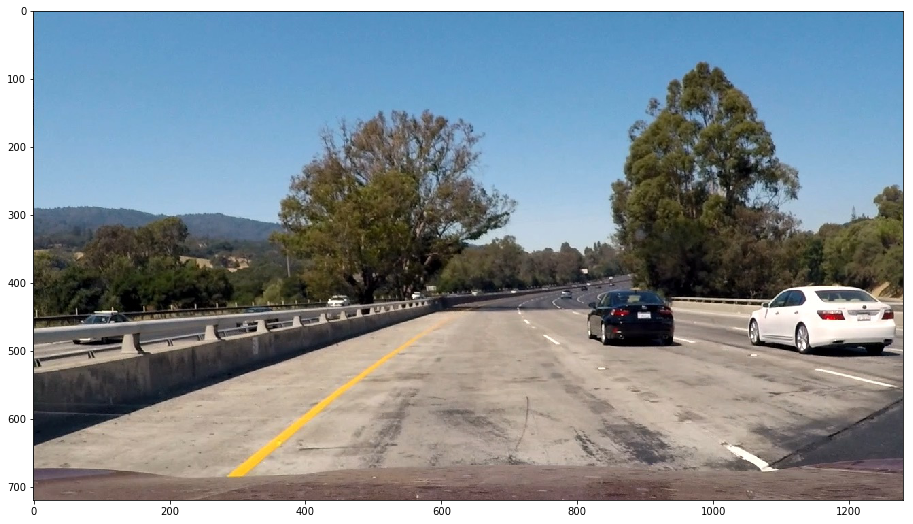

In [312]:
image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, "test{}.jpg".format(1)))
%time image = process_frame(image)
print("Buffer Length", len(buffer))
plt.figure(figsize=(18,9))
plt.imshow(image)

### Video Implementation

In [383]:
input1 = os.path.join(INPUT_VIDEOS_DIR, "test_video2.mp4")
output1 = os.path.join(OUTPUT_VIDEOS_DIR, "test_video2_process.mp4")
clip1 = VideoFileClip(input1)
project_clip = clip1.fl_image(process_frame)
%time project_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video output_videos/test_video2_process.mp4
[MoviePy] Writing video output_videos/test_video2_process.mp4


100%|██████████| 128/128 [03:59<00:00,  2.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video2_process.mp4 

CPU times: user 3min 56s, sys: 2.86 s, total: 3min 58s
Wall time: 4min


In [384]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))